In [1]:
!pip install -e ../../.
from climpyrical.mask import *
from climpyrical.gridding import *
from climpyrical.datacube import *

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd

from sklearn import ensemble
import seaborn as sns
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats

from sklearn.metrics.pairwise import paired_distances
from scipy.spatial import distance
from scipy.stats import linregress

import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots
import chart_studio.plotly as py
from plotly import colors as clr
import chart_studio

chart_studio.tools.set_config_file(world_readable=False,
                             sharing='private')

from jupyter_helpers.notifications import Notifications
Notifications(
 time_threshold=2,
    integration='GNOME'
)

%load_ext autoreload
%autoreload 2



Obtaining file:///home/nannau/03132020
  Found existing installation: climpyrical 0.1.dev0
    Uninstalling climpyrical-0.1.dev0:
      Successfully uninstalled climpyrical-0.1.dev0
  Running setup.py develop for climpyrical
You are using pip version 18.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
xr.open_dataset('/home/nannau/snow_only_ensemble.nc')

<xarray.Dataset>
Dimensions:       (level: 35, rlat: 130, rlon: 155)
Coordinates:
    lon           (rlat, rlon) float64 ...
    lat           (rlat, rlon) float64 ...
  * rlon          (rlon) float64 -33.88 -33.44 -33.0 -32.56 ... 33.0 33.44 33.88
  * rlat          (rlat) float64 -28.6 -28.16 -27.72 ... 27.28 27.72 28.16
  * level         (level) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0
Data variables:
    rotated_pole  int32 ...
    snw           (level, rlat, rlon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Wed Sep 11 10:17:05 2019: cdo setmissval,1.00000002004088e+...
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...

In [3]:
PATH = '../../climpyrical/tests/data/snow_only_ensemble.nc'
dv = 'snw'
dsold = read_data(PATH, dv)

NNN = 3
ds = regrid_ensemble(dsold, dv, NNN)
# import scipy
rlonold, rlatold = np.meshgrid(dsold.rlon.values, dsold.rlat.values)
# np.stack([rlon.flatten(), rlat.flatten()]).shape, ds[dv].values[0, ...].flatten().shape
# finter = scipy.interpolate.interp2d(np.stack([rlon.flatten(), rlat.flatten()]).T[:, 1], np.stack([rlon.flatten(), rlat.flatten()]).T[:, 0], dsold[dv].values[0, ...].flatten(), kind='linear')
rlonn, rlatn = np.meshgrid(ds.rlon.values, ds.rlat.values)
# ds.rlon.values

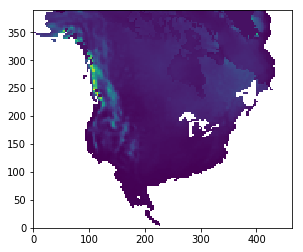

In [4]:
plt.imshow(ds[dv].values[0, ...], origin='lower')
plt.show()

In [5]:
from scipy.interpolate import griddata

interped = np.array([griddata(np.stack([rlonold.flatten(), rlatold.flatten()]).T, dsold[dv].values[i, ...].flatten(), (rlonn, rlatn), method='nearest') for i in range(35)])

In [6]:
interped.shape
ds = ds.assign(snw=(ds.dims, interped))

In [7]:
ds

<xarray.Dataset>
Dimensions:  (level: 35, rlat: 390, rlon: 465)
Coordinates:
  * rlat     (rlat) float64 -28.75 -28.6 -28.45 -28.31 ... 28.01 28.16 28.31
  * rlon     (rlon) float64 -34.03 -33.88 -33.73 -33.59 ... 33.73 33.88 34.03
    lat      (rlat, rlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    lon      (rlat, rlon) float64 nan nan nan nan nan ... nan nan nan nan nan
  * level    (level) int64 1 2 3 4 5 6 7 8 9 10 ... 27 28 29 30 31 32 33 34 35
Data variables:
    snw      (level, rlat, rlon) float32 nan nan nan nan nan ... nan nan nan nan

In [8]:
shape = ds[dv].values[0, ...].copy().shape

In [9]:
!ls ../../climpyrical/tests/data/land_mask_CanRCM4_sftlf.nc

../../climpyrical/tests/data/land_mask_CanRCM4_sftlf.nc


In [10]:
mask = read_data('../../climpyrical/tests/data/land_mask_CanRCM4_sftlf.nc', design_value_name='sftlf', keys={'rlat', 
'rlon'})
mask['sftlf'].ndim

3

In [11]:
# mask = read_data('../../climpyrical/tests/data/land_mask_CanRCM4_sftlf.nc', design_value_name='sftlf', keys={'rlat', 
# 'rlon'})
# dvmask = 'sftlf'
# mask
# mask = mask.squeeze('time')
# mask = mask.drop('time')
# print(mask[dvmask].shape)
# mask = regrid_ensemble(mask, 'sftlf', NNN, keys={'rlat', 'rlon'})
# ismasked = mask[dvmask].values >= 1.0
# ismasked = ~ismasked
# plt.imshow(ismasked, origin='lower')

In [12]:
True + True

2

In [13]:
ens_mean = np.mean(ds[dv].values, axis=0)
ens_mean.shape

flat_mask_with_extra_nan = ~np.isnan(ens_mean)# + ismasked > 0
flat_mask_with_extra_nan = flat_mask_with_extra_nan.flatten()
flat_mask_with_extra_nan

array([False, False, False, ..., False, False, False])

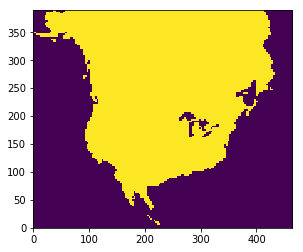

In [14]:
# Create a mask of extra NaN values that is flattened
# flat_mask_with_extra_nan = ~np.logical_and(np.isnan(ens_mean.flatten()), ~mask.flatten())
# flat_mask_with_extra_nan = np.logical_and(~np.isnan(ens_mean.flatten()), mask.flatten())
# print(np.sum(np.isnan(ens_mean)), np.sum(~mask), np.sum(~flat_mask_with_extra_nan))

# Put back into the spatial shape
final_mask = flat_mask_with_extra_nan.reshape(ens_mean.shape)

# create two grids of rlon and rlat to use new mask with
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

# check that the shapes of all of the arrays after masking are consistent
assert rlat[final_mask].shape == rlon[final_mask].shape and ens_mean[final_mask].shape == rlat[final_mask].shape
plt.imshow(final_mask, origin='lower')

In [15]:
# Create a mask of extra NaN values that is flattened
# flat_mask_with_extra_nan = np.logical_or(np.isnan(ens_mean.flatten()), ~mask.flatten())
# flat_mask_with_extra_nan2 = np.logical_and(~np.isnan(ens_mean.flatten()), mask.flatten())
print("\n", "Ensemble count: ", np.sum(~np.isnan(ens_mean)), "\n",
      "Mask count: ", np.sum(mask), "\n", 
      "Combined count: ", np.sum(flat_mask_with_extra_nan))
# print(np.allclose(flat_mask_with_extra_nan, flat_mask_with_extra_nan2))
# Put back into the spatial shape
# final_mask2 = flat_mask_with_extra_nan.reshape(ens_mean.shape)

# create two grids of rlon and rlat to use new mask with
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

# check that the shapes of all of the arrays after masking are consistent
assert rlat[final_mask].shape == rlon[final_mask].shape and ens_mean[final_mask].shape == rlat[final_mask].shape


 Ensemble count:  89505 
 Mask count:  <xarray.Dataset>
Dimensions:  ()
Data variables:
    sftlf    float32 902200.0 
 Combined count:  89505


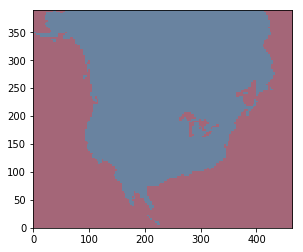

In [16]:
plt.imshow(final_mask, origin='lower', cmap='RdBu', alpha=0.6)
# plt.imshow(final_mask2, origin='lower', alpha=0.6)

In [17]:
df = pd.read_csv('../../climpyrical/tests/data/sl50_short.csv', index_col=None)
station_dv = 'SL50 (kPa)'

# transform into rotated pole
rlon_st, rlat_st = transform_coords(df['lon'].values, df['lat'].values)
df = df.assign(
        rlon=rlon_st, 
        rlat=rlat_st
)
df = df[df[station_dv] != 0.0]

# Add nearest rlon and rlat locations in grid to stations
rlon_nearest_index, rlat_nearest_index = find_element_wise_nearest_pos(ds.rlon.values, ds.rlat.values, df.rlon.values, df.rlat.values)

# df = df.assign(
#         rlon=rlon[rlat_nearest_index, rlon_nearest_index], 
#         rlat=rlat[rlat_nearest_index, rlon_nearest_index]
# )

df = df.assign(
    label='stations',
    rlon_nearest_index = rlon_nearest_index, 
    rlat_nearest_index = rlat_nearest_index,
    nearest_grid = list(zip(rlon_nearest_index, rlat_nearest_index))
)

# Group together stations falling in same grid cell and take mean
df = df.groupby(['nearest_grid'], as_index=False).agg({
                                station_dv: 'mean',
                                'lat':'mean',
                                'lon':'mean',
                                'rlat': 'mean',
                                'rlon': 'mean',
                                'rlon_nearest_index':'mean',
                                'rlat_nearest_index':'mean',
                                'label': 'min',
                            })

rlon_nearest_index, rlat_nearest_index = find_element_wise_nearest_pos(ds.rlon.values, ds.rlat.values, df.rlon.values, df.rlat.values)


# Get the indices for each grid axis that are matched and grouped
# rlon_i_agg, rlat_i_agg = ndf.rlon_nearest_index.values, ndf.rlat_nearest_index.values
# plt.imshow(final_mask, origin='lower')
offshore_mask = ~final_mask[rlat_nearest_index, rlon_nearest_index]

/home/nannau/03132020/climpyrical/gridding.py:396: UserWarning:

36.222662646628834 is outside of array's domain between -28.746663224173453 and 28.3066665048131.             A station is outside of the CanRCM4 model grid space.

/home/nannau/03132020/climpyrical/gridding.py:396: UserWarning:

32.64541886648805 is outside of array's domain between -28.746663224173453 and 28.3066665048131.             A station is outside of the CanRCM4 model grid space.

/home/nannau/03132020/climpyrical/gridding.py:396: UserWarning:

31.345755932126362 is outside of array's domain between -28.746663224173453 and 28.3066665048131.             A station is outside of the CanRCM4 model grid space.

/home/nannau/03132020/climpyrical/gridding.py:396: UserWarning:

29.59681105435813 is outside of array's domain between -28.746663224173453 and 28.3066665048131.             A station is outside of the CanRCM4 model grid space.



In [18]:
hasnan = ~final_mask[rlat_nearest_index, rlon_nearest_index]
xnan = df.rlon.values#[hasnan]#rlon[rlat_nearest_index, rlon_nearest_index][hasnan]
ynan = df.rlat.values#[hasnan]#rlat[rlat_nearest_index, rlon_nearest_index][hasnan]
xnan, ynan

rlon[final_mask], rlat[final_mask]

nearest_gridcell_idx = pairwise_distances_argmin_min( 
    np.deg2rad(
    np.stack([xnan, ynan]).T
    ),
    np.deg2rad(np.stack([rlon.copy()[final_mask], rlat.copy()[final_mask]]).T), 
    metric='haversine'
)[0]

irlon, irlat = np.meshgrid(range(ds.rlon.size), range(ds.rlat.size))

station_indexes = np.stack([irlon[final_mask], irlat[final_mask]])[:, nearest_gridcell_idx]

ix, iy = station_indexes
matched_df = pd.DataFrame({'ilocy': iy, 'ilocx': ix, station_dv: df[station_dv].values})
matched_df = matched_df.groupby(['ilocy', 'ilocx'], as_index=False).agg({station_dv: 'mean'})#, 'niy': 'min', 'nix': 'min'})
matched_df
iy = matched_df.ilocy.values
ix = matched_df.ilocx.values
station_vals = matched_df[station_dv].values
matched_df['rlon'] = rlon[iy, ix]
matched_df['rlat'] = rlat[iy, ix]
matched_df['lat'] = ds.lat.values[iy, ix]
matched_df['lon'] = ds.lon.values[iy, ix]
matched_df

,ilocy,ilocx,SL50 (kPa),rlon,rlat,lat,lon
0,167,303,1.05,10.413335,-4.253331,NaN,NaN
1,172,305,1.50,10.706668,-3.519998,NaN,NaN
2,173,311,1.50,11.586668,-3.373331,NaN,NaN
3,173,314,1.60,12.026668,-3.373331,NaN,NaN
4,174,311,1.80,11.586668,-3.226665,NaN,NaN
...,...,...,...,...,...,...,...
444,382,236,1.40,0.586667,27.280000,NaN,NaN
445,389,191,1.20,-6.013334,28.306667,NaN,NaN
446,389,222,1.60,-1.466667,28.306667,NaN,NaN
447,389,248,0.90,2.346667,28.306667,NaN,NaN


In [19]:

X = np.stack(
        [
            rlon[iy, ix], 
            rlat[iy, ix]
        ]
).T

Xf = np.stack([rlon[final_mask], rlat[final_mask]]).T


model_arr = np.array(
                [
                    ds[dv].values.copy()[i, iy, ix] for i in range(35)
                ]
)

ratio = station_vals/model_arr
ratio

mask_zero = ~np.isclose(model_arr, 0.)
print(ratio.shape)
ratio = ratio[..., mask_zero[0, ...]].copy()
X = X[mask_zero[0, ...]].copy()
X.shape, ratio.shape
assert ~np.any(np.isnan(X)) and ~np.any(np.isnan(ratio))

(35, 449)


In [20]:
assert ~np.any(np.isnan(model_arr))

In [21]:
%%time
from sklearn.model_selection import LeaveOneOut
warnings.filterwarnings('ignore')
predlist = []
predfull = []
params_fit = []
parameters = {'n_neighbors': range(2, 50)}

# model = KNeighborsRegressor(weights='distance')
# clf = LeaveOneOut(model, parameters, cv=10)

for i in range(35):
    model = KNeighborsRegressor(weights='distance')
    clf = GridSearchCV(model, parameters, cv=X.shape[1])
    clf.fit(X, ratio[i, ...])
    predlist.append(clf.predict(X))
    predfull.append(clf.predict(Xf))
    params_fit.append(clf.best_params_)

CPU times: user 12 s, sys: 82.2 ms, total: 12.1 s
Wall time: 12.1 s


In [22]:
preds = np.array(predlist)
# preds = preds*model_arr
predsfull = np.array(predfull)#*ds[dv].values[:, final_mask]
np.any(~np.isin(model_arr, ds[dv].values))

False

In [23]:
preds.shape

(35, 449)

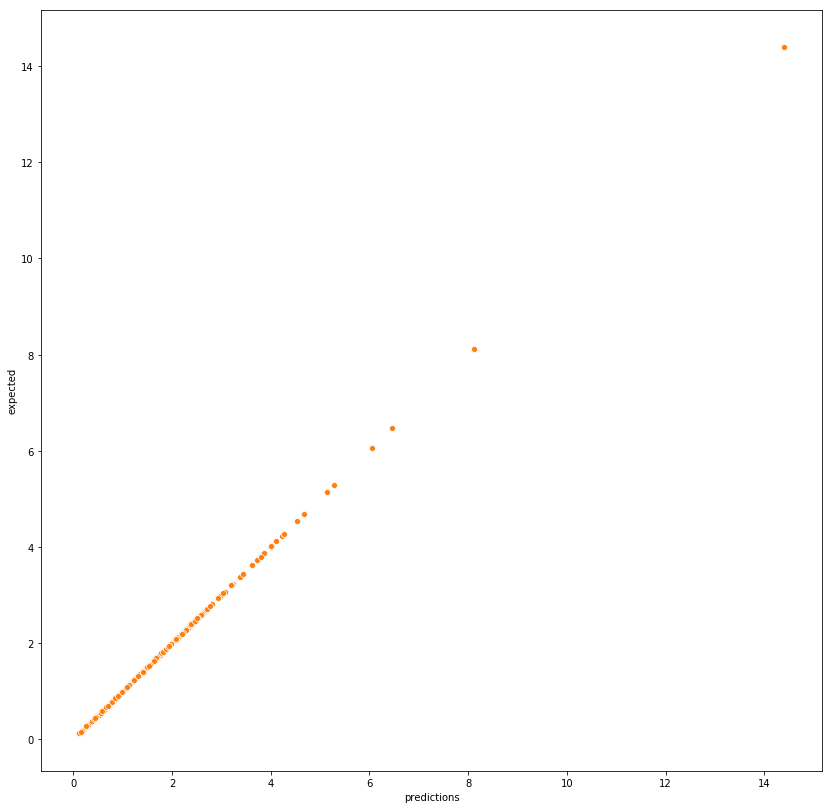

In [24]:
S = ds[dv].values.copy()

S[:, final_mask] = predsfull

plt.figure(figsize=(14, 14))
plt.xlabel('predictions')
plt.ylabel('expected')

idx=33
weird = np.array([np.isclose(S[idx, iy, ix]/preds[idx, :], 1.0, atol=0.1) for idx in range(35)])
# weird = np.array([np.isclose(S[idx, iy, ix], ratio[idx, ...], atol=0.1) for idx in range(35)])
weird = np.any(weird==False, axis=0)
sns.scatterplot(S[0, iy, ix], preds[0, :])
sns.scatterplot(S[0, iy, ix], ratio[0, ...])

In [25]:
np.sum(weird)

0

In [26]:
ds.coords

Coordinates:
  * rlat     (rlat) float64 -28.75 -28.6 -28.45 -28.31 ... 28.01 28.16 28.31
  * rlon     (rlon) float64 -34.03 -33.88 -33.73 -33.59 ... 33.73 33.88 34.03
    lat      (rlat, rlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    lon      (rlat, rlon) float64 nan nan nan nan nan ... nan nan nan nan nan
  * level    (level) int64 1 2 3 4 5 6 7 8 9 10 ... 27 28 29 30 31 32 33 34 35

In [27]:
np.sum(~weird)
nanloc = np.isnan(ds[dv].values[0, rlat_nearest_index, rlon_nearest_index])
np.any(nanloc)

True

In [28]:
ks = np.array([t['n_neighbors'] for t in params_fit])
ks

array([16, 15, 15, 21, 16, 15, 15, 15, 15, 16, 20, 15, 15, 20, 16, 15, 15,
       15, 20, 16, 20, 16, 15, 49, 16, 46, 15, 15, 15, 16, 15, 46, 15, 16,
       15])

In [29]:
model = KNeighborsRegressor(n_neighbors=9, weights='distance')
model.fit(X, ratio[0, ...])

def pwhole_(alpha, k, Y):
    rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
    d_gridx = np.dstack((rlon, rlat))
    a = np.array([rlon[final_mask], rlat[final_mask]]).T
#     a1 = np.array([df['rlon'].values, df['rlat'].values]).T
    a1 = np.array([rlon[iy, ix], rlat[iy, ix]]).T
    model = KNeighborsRegressor(n_neighbors=k, weights='distance')
    model.fit(X, Y)
    d = model.kneighbors_graph(a, mode='distance').toarray()
    fracs = np.linspace(0.2, -5)
    residual = []
    residual_plain = []
    residual_inv=[]
    psumar=[]

    denom = np.exp(-alpha*np.sum(np.sort(d, axis=1)[:, :1], axis=1))
    num = np.exp(-alpha*np.sort(distance.cdist(a, a1), axis=1)[:, 0])

    p = num/denom
    pwhole = ens_mean.copy()
    pwhole[final_mask] = p
    pwhole[~final_mask] = np.nan
    return pwhole.reshape(ens_mean.shape)


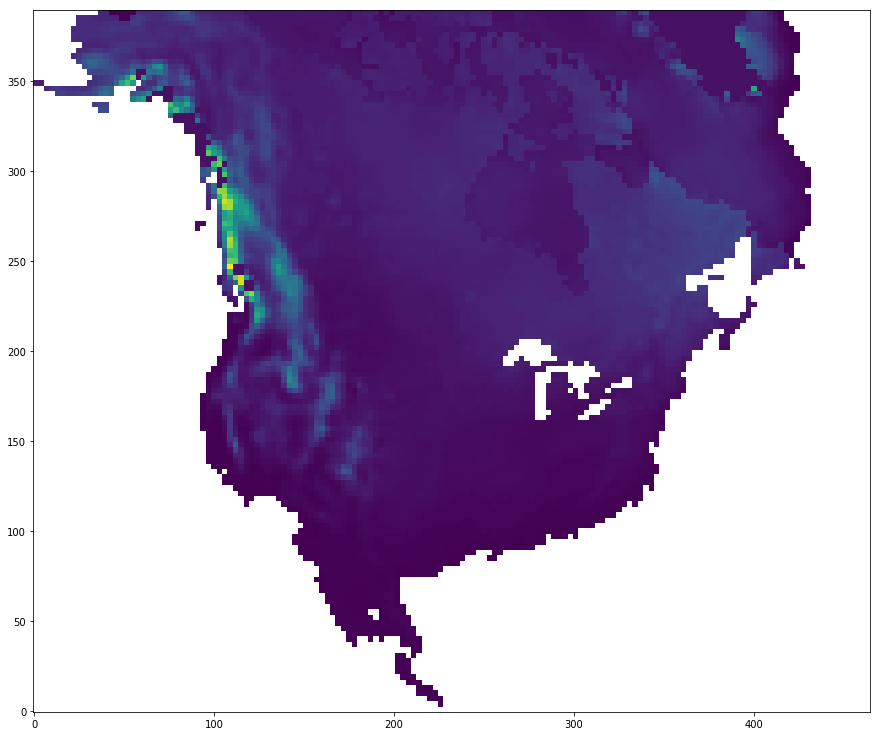

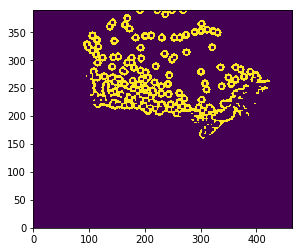

In [30]:
plt.figure(figsize=(15, 15))
plt.imshow(pwhole_(.25, 12, station_vals), origin='lower')
plt.imshow(ds[dv].values[0, ...], origin='lower')
plt.show()
plt.imshow(np.isclose(pwhole_(1, 12, station_vals), 0.5, atol=0.15),  origin='lower')
plt.show()

In [31]:
import random

In [32]:
%%time
full_errors = []
full_errors_model = []
ns = []
alas = np.linspace(0.1, 1.8, 10)

def returnval(alpha, k):
    alphas = pwhole_(alpha, k, station_vals)
    inflection = np.isclose(alphas, 0.5, atol=0.05)
    
    R = (np.ones(S[i, ...].shape)*(1.0-alphas))+alphas*S[i, ...]
    R = R*ds[dv].values[i, ...]        
    
    A, B = ds[dv].values[i, inflection], S[i, inflection]
    
    random.seed = 42
    idx = random.sample(range(A.size), 500)
    
    A = A[idx]
    B = B[idx]
    
    return mean_squared_error(A, B)
    
def loop2(alpha, ks):
    errors = np.array([returnval(alpha, k) for k in ks])
    return errors 

    
def loop1(alas, ks):
    errors = np.array([loop2(alpha, ks) for alpha in alas])
    return errors

full_errors = loop1(alas, ks)

CPU times: user 10min 15s, sys: 1min 3s, total: 11min 18s
Wall time: 11min 19s


In [33]:
dferr = pd.DataFrame()
dferr = dferr.assign(alpha = np.repeat(alas, ks.size))
dferr = dferr.assign(RMSE = full_errors.flatten())
dferr = dferr.assign(model = np.tile(np.arange(1, ks.size+1), alas.size))
import plotly.express as px

fig = px.line(dferr, 
              x="alpha", 
              y="RMSE", 
              title='Ensemble Members RMSE at 50% Contribution Level', 
              color='model')

plotly.offline.plot(fig, filename='errors.html')

'errors.html'

In [34]:
min_alphas = alas[np.argmin(full_errors, axis=0)]
pwhole_final = np.array([pwhole_(alpha, ks[i], station_vals) for i, alpha in enumerate(min_alphas)])

R_final = (np.ones(S[i, ...].shape)*(1.0-pwhole_final))+pwhole_final*S[i, ...]
R_final = R_final*ds[dv].values[i, ...]

inflection = np.isclose(pwhole_final, 0.5, atol=0.15)
rmse = np.array([np.sqrt(mean_squared_error(ds[dv].values[i, inflection[i, ...]], S[i, inflection[i, ...]])) for i in range(ks.size)])
R_final = R_final[np.argmin(rmse), ...]

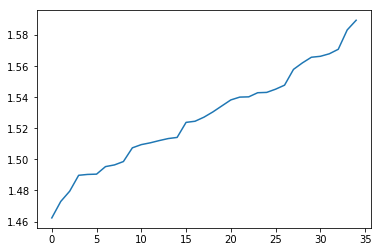

In [35]:
plt.plot(np.arange(ks.size), rmse[np.argsort(rmse)])

In [36]:
# Rcp = np.mean(R_final.copy(), axis=0)
Rcp =R_final.copy()
# 
Rcp[~final_mask] = np.nan

In [37]:
import matplotlib
from matplotlib import cm
import numpy as np

magma_cmap = matplotlib.cm.get_cmap('RdBu', 35)
norm = matplotlib.colors.Normalize(vmin=0, vmax=255)

magma_rgb = []

for i in range(0, 255):
    k = matplotlib.colors.colorConverter.to_rgb(magma_cmap(norm(i)))
    magma_rgb.append(k)

def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale

magma = matplotlib_to_plotly(magma_cmap, 35)
new_magma = []
for i, color in enumerate(magma):
    if i < len(magma)-1:
        new_magma.append(color)
        new_magma.append(magma[i+1])

nmcopy = []        
for i in range(len(new_magma)):
    if i < len(new_magma)-1:
        nmcopy.append([new_magma[i][0], new_magma[i+1][1]])

nmcopy.append(magma[len(magma)-1])

In [38]:
np.nanmax(Rcp)

20.400000721546803

In [39]:
fig = make_subplots(
    rows=4, cols=1, 
            subplot_titles=("Reconstruction View #1",
                            "Reconstruction View #2",
                            "Reconstruction View #3",
                            "Top N Ensemble Mean"),
            specs=[[{"type": "scatter"}],
                    [{"type": "scatter"}],
                    [{"type": "scatter"}],
                    [{"type": "scatter"}],
                   ])

fig.add_trace(
    go.Heatmap(
        z=np.mean(ds[dv].values[np.argmin(rmse), ...], axis=0),
        x=ds.rlon.values,
        y=ds.rlat.values,
        zmin=0,
        zmax=20.,
        hoverongaps = False,
        colorscale=nmcopy,
        showscale=True,
                    colorbar=dict(
                title=dv, 
                len=.65, 
                x=-0.15, 
                y=.7
            ),
        hovertemplate =
        "<b>Reconstructed Value: %{z} </b><br>" +
        "rlon: %{x}<br>" +
        "rlat: %{y}<br>" ,
        name="Reconstruction", 
#         colorbar=dict(title=dv, len=1.5, x=-0.2, y=.75),
        
    ),
    row=4, col=1
)

fig.add_trace(
    go.Heatmap(
        z=Rcp,
        x=ds.rlon.values,
        y=ds.rlat.values,
        zmin=0,
        zmax=20.,
        hoverongaps = False,
        colorscale=nmcopy,
        showscale=True,
                    colorbar=dict(
                title=dv, 
                len=.65, 
                x=-0.15, 
                y=.7
            ),
        hovertemplate =
        "<b>Reconstructed Value: %{z} </b><br>" +
        "rlon: %{x}<br>" +
        "rlat: %{y}<br>" ,
        name="Reconstruction", 
#         colorbar=dict(title=dv, len=1.5, x=-0.2, y=.75),
        
    ),
    row=1, col=1
)

fig.add_scatter(
        x=rlon[iy, ix],
        y=rlat[iy, ix],
        mode='markers',
        marker=dict(
            symbol='x',
            color=matched_df[station_dv].values, 
           colorscale=nmcopy,
            colorbar=dict(
                title=dv, 
                len=.65, 
                x=-0.15, 
                y=.7
            ),
            line=dict(width=0.35, color='DarkSlateGrey'),
            showscale=False,
        ),
        text = df[station_dv].values,
        hoverinfo = 'text',
        hovertemplate =
            "<b>Station Value: %{text} </b><br>" +
            "rlon: %{x}<br>" +
            "rlat: %{y}<br>",
    name=" Stations on Reconstruction",
    row=1,
    col=1   
)


fig.add_trace(
    go.Heatmap(
        z=S[np.argmin(rmse), ...]*ds[dv].values[np.argmin(rmse), ...],
        x=ds.rlon.values,
        y=ds.rlat.values,
        zmin=0,
        zmax=20.,
        hoverongaps = False,
        colorscale=nmcopy,
        showscale=True,
                    colorbar=dict(
                title=dv, 
                len=.65, 
                x=-0.15, 
                y=.7
            ),
        text = pwhole_final[0 ,...],
        hovertemplate =
        "<b>Reconstructed Value: %{z} </b><br>" +
        "rlon: %{x}<br>" +
        "rlat: %{y}<br>" +
        "alpha: %{text}<br>",
        name="Reconstruction", 
#         colorbar=dict(title=dv, len=1.5, x=-0.2, y=.75),
        
    ),
    row=2, col=1
)

fig.add_scatter(
        x=rlon[iy, ix],
        y=rlat[iy, ix],
        mode='markers',
        marker=dict(
            symbol='x',
            color=matched_df[station_dv].values, 
            colorscale=nmcopy,
            colorbar=dict(
                title=dv, 
                len=.65, 
                x=-0.15, 
                y=.7
            ),
            line=dict(width=0.35, color='DarkSlateGrey'),
            showscale=False,
        ),
        text = matched_df[station_dv].values,
        hoverinfo = 'text',
        hovertemplate =
            "<b>Station Value: %{text} </b><br>" +
            "rlon: %{x}<br>" +
            "rlat: %{y}<br>",
    name=" Stations on Reconstruction",
    row=2,
    col=1   
)

fig.add_trace(
    go.Heatmap(
        z=S[np.argmin(rmse), ...],
        x=ds.rlon.values,
        y=ds.rlat.values,
        zmin=0,
        zmax=3.,
        hoverongaps = False,
        colorscale='RdBu',
        hovertemplate =
        "<b>Reconstructed Value: %{z} </b><br>" +
        "rlon: %{x}<br>" +
        "rlat: %{y}<br>" ,
        name="Reconstruction", 
#         colorbar=dict(title=dv, len=1.5, x=-0.2, y=.75),
        
    ),
    row=3, col=1
)

fig.add_scatter(
        x=rlon[iy, ix],
        y=rlat[iy, ix],
        mode='markers',
        marker=dict(
            symbol='x',
            color=ratio[np.argmin(rmse)], 
            colorscale='RdBu',
            cmin=0.,
            cmax=3.,
            colorbar=dict(
                title=dv, 
                len=.65, 
                x=-.5,
                y=.7
            ),
            line=dict(width=0.35, color='DarkSlateGrey'),
            showscale=False,
        ),
        text = ratio[np.argmin(rmse)],
        hoverinfo = 'text',
        hovertemplate =
            "<b>Station Value: %{text} </b><br>" +
            "rlon: %{x}<br>" +
            "rlat: %{y}<br>",
    name=" Stations on Reconstruction",
    row=3,
    col=1   
)

fig.update_layout(
    title="<b>National Building Code K Nearest Neighbour Regression Results</b> Nic Annau, PCIC",
    font=dict(size=24),
    margin=dict(b=30),
    width=1800, 
    height=5130,
    showlegend=True,
    legend_orientation="v",
)


fig.update_yaxes(title="rlat", range=[df.rlat.values.min()-2, df.rlat.values.max()+2], row=1, col=1)
fig.update_yaxes(title="rlat", range=[df.rlat.values.min()-2, df.rlat.values.max()+2], row=1, col=2)
fig.update_yaxes(title="rlat", range=[df.rlat.values.min()-2, df.rlat.values.max()+2], row=2, col=1)



# fig.update_yaxes(title="Reconstruction", range=[(Y.flatten()**2).min()-0.2, (Y.flatten()**2).max()+0.2], row=1, col=2)
# fig.update_yaxes(title="Reconstruction", range=[(Y.flatten()**2).min()-0.2, (Y.flatten()**2).max()+0.2], row=2, col=2)

fig.update_xaxes(title="rlon", range=[df.rlon.values.min()-2, df.rlon.values.max()+2], row=1, col=1)
fig.update_xaxes(title="rlon", range=[df.rlon.values.min()-2, df.rlon.values.max()+2], row=1, col=2)
fig.update_xaxes(title="rlon", range=[df.rlon.values.min()-2, df.rlon.values.max()+2], row=2, col=1)

plotly.offline.plot(fig, filename='continuous_snow.html')

'continuous_snow.html'

In [40]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()


def pwhole_model(alpha, model, iy, ix):
    rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
    d_gridx = np.dstack((rlon, rlat))
    a = np.array([rlon[final_mask], rlat[final_mask]]).T
    a1 = np.array([rlon[iy, ix], rlat[iy, ix]]).T
    
    d = model.kneighbors_graph(a, mode='distance').toarray()
    denom = np.exp(-alpha*np.sum(np.sort(d, axis=1)[:, :1], axis=1))
    num = np.exp(-alpha*np.sort(distance.cdist(a, a1), axis=1)[:, 0])

    p = num/denom
    pwhole = ens_mean.copy()
    pwhole[final_mask] = p
    pwhole[~final_mask] = np.nan
    return pwhole.reshape(ens_mean.shape)
loormse_ens = []
loormse_ens_post = []
for i in np.argsort(rmse)[:5]:
    print(i)
    loormse = []
    loormse_post = []
    for train_index, test_index in loo.split(ratio[i, ...]):
        model = KNeighborsRegressor(n_neighbors=ks[i], weights='distance')
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = ratio[i, train_index], ratio[i, test_index]
        model.fit(X_train, y_train)
#         ixt, iyt = find_element_wise_nearest_pos(ds.rlon.values, ds.rlat.values, X_train[:, 0], X_train[:,1])
        
#         ixt, iyt = find_nearest_index(ds.rlon.values, X_test[0, 0]), find_nearest_index(ds.rlat.values, X_test[0, 1])
        
#         rho = pwhole_model(min_alphas[i], model, iy, ix)[ixt, iyt]
    
        Sloo = model.predict(X_test)
#         Rloo = (1.0 - rho)+rho*Sloo
#         lrmse=np.sqrt(mean_squared_error(Rloo*ds[dv].values[i, iy, ix][test_index], station_vals[test_index]))
#         loormse_post.append(lrmse)
        loormse_post.append(np.sqrt(mean_squared_error(Sloo*ds[dv].values[i, iy[test_index], ix[test_index]], station_vals[test_index])))
        loormse.append(np.sqrt(mean_squared_error(Sloo, y_test)))
    loormse_ens_post.append(loormse_post)
    loormse_ens.append(loormse)

29
23
25
20
28


In [41]:
loormse_ens = np.array(loormse_ens)
loormse_ens_post = np.array(loormse_ens_post)
np.mean(loormse_ens, axis=1), np.mean(loormse_ens_post, axis=1)

(array([0.48563474, 0.51078153, 0.517811  , 0.47517052, 0.4725024 ]),
 array([1.0457819 , 1.08368673, 1.11059226, 1.05692705, 1.04192421]))

In [42]:
loormse = np.array(loormse)
matched_df = matched_df.assign(loormse_min = loormse_ens[0, ...])

In [43]:
source_crs={"init": "epsg:4326"}
target_crs={
    "proj": "ob_tran",
    "o_proj": "longlat",
    "lon_0": -97,
    "o_lat_p": 42.5,
    "a": 6378137,
    "to_meter": 0.0174532925199,
    "no_defs": True,
}

matched_df['loormse_min'] = loormse_ens[0, ...]
matched_df['loormse_min_post'] = loormse_ens_post[0, ...]
matched_df['ratio'] = ratio[np.argmin(rmse), ...]

df_copy = matched_df.copy()

df_copy['lon'], df_copy['lat'] = transform_coords(df_copy.rlon.values, df_copy.rlat.values, source_crs=target_crs, target_crs=source_crs)
df_copy = df_copy[(df_copy.lon > -95) & (df_copy.lon < -50) & (df_copy.lat > 30) & (df_copy.lat < 65)]

l, r = find_nearest_index(ds.rlon.values, df_copy.rlon.min()), find_nearest_index(ds.rlon.values, df_copy.rlon.max())
u, lw = find_nearest_index(ds.rlat.values, df_copy.rlat.min()), find_nearest_index(ds.rlat.values, df_copy.rlat.max())

l, r, u, lw

(241, 427, 167, 323)

In [44]:
df_copy.loormse_min/df_copy.ratio.max()*100, df_copy.ratio.max()

(0       1.658000
 1       2.909855
 2       1.315211
 3       2.346551
 4       0.399461
          ...    
 400     1.588144
 406     5.715666
 411     9.795049
 415     4.421372
 419    11.468847
 Name: loormse_min, Length: 248, dtype: float64, 12.413857910549009)

In [45]:
mask_copy = final_mask.copy()
mask_copy1 = mask_copy.copy()
mask_copy1[...] = False
mask_copy1[u:lw, l:r] = True
mask_copy[iy, ix] = True

mask_copy = np.logical_and(mask_copy, mask_copy1)

mask_copy_gt50 = np.logical_and(mask_copy, pwhole_final[np.argmin(rmse), ...] >= 0.5)
mask_copy_lt50 = np.logical_and(mask_copy, pwhole_final[np.argmin(rmse), ...] <= 0.5)
mask_copy_lt20 = np.logical_and(mask_copy, pwhole_final[np.argmin(rmse), ...] <= 0.2)

np.sqrt(mean_squared_error(Rcp[mask_copy], ds[dv].values[np.argmin(rmse), mask_copy])), np.sqrt(mean_squared_error(S[np.argmin(rmse), mask_copy]*ds[dv].values[np.argmin(rmse), mask_copy], ds[dv].values[np.argmin(rmse), mask_copy]))

(1.9240463233151373, 2.8283122)

nan

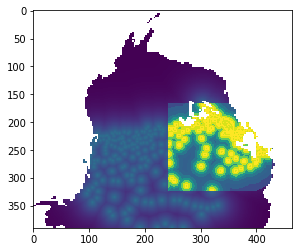

In [46]:
prho = pwhole_final[np.argmin(rmse), ...].copy()
mc = mask_copy.copy()
for level in np.linspace(.1, 1.0, 10):
    mc = mask_copy.copy()
    mc = np.logical_and(mc, np.isclose(pwhole_final[np.argmin(rmse), ...].copy(), level, atol=.05))
    prho[mc] = np.sqrt(mean_squared_error(Rcp[mc], ds[dv].values[np.argmin(rmse), mc]))
plt.imshow(prho)
np.max(prho[u:lw, l:r])

In [72]:
np.linspace(0, 14, 8)

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14.])

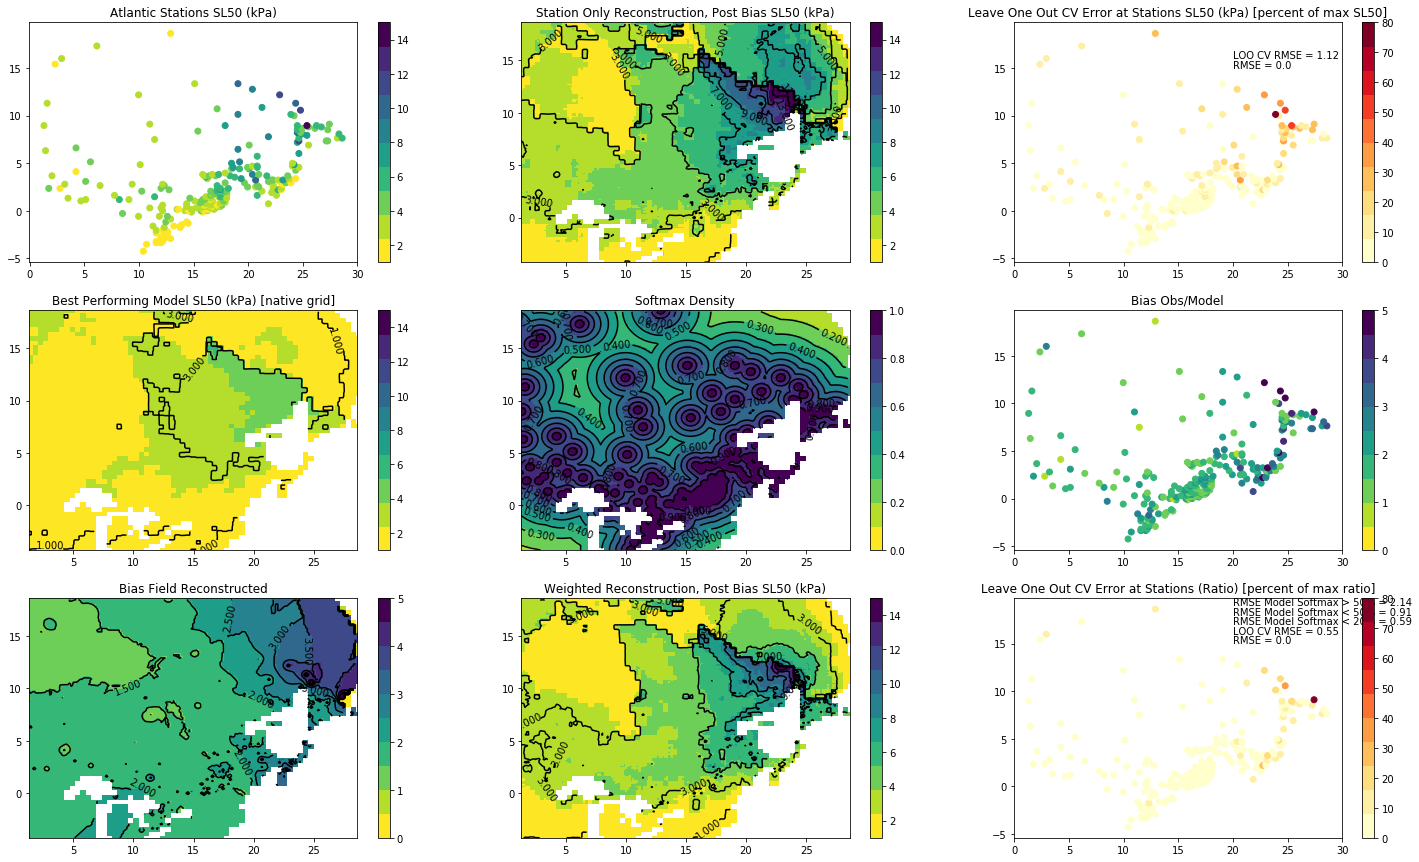

In [87]:
fig, ax = plt.subplots(3, 3, figsize=(25, 15))
zmin,zmax = 1, 15

stations_only = ax[0,0].scatter(df_copy.rlon, df_copy.rlat, c = df_copy[station_dv], cmap=plt.cm.get_cmap("viridis_r", 10),  vmin=zmin, vmax=zmax)
ax[0, 0].set_title('Atlantic Stations SL50 (kPa)') 

S_only_ps = ax[0, 1].imshow(S[np.argmin(rmse), u:lw, l:r].reshape((lw-u, r-l))*ds[dv].values[np.argmin(rmse), u:lw, l:r].reshape((lw-u, r-l)), origin='lower', aspect='auto', extent=[df_copy.rlon.min(), df_copy.rlon.max(), df_copy.rlat.min(), df_copy.rlat.max()], cmap=plt.cm.get_cmap("viridis_r", 10), vmin=zmin, vmax=zmax)
ax[0, 1].set_title('Station Only Reconstruction, Post Bias SL50 (kPa)') 
ct_S_only_ps = ax[0, 1].contour(
    rlon[u:lw, l:r].reshape((lw-u, r-l)), 
    rlat[u:lw, l:r].reshape((lw-u, r-l)), 
    S[np.argmin(rmse), u:lw, l:r].reshape((lw-u, r-l))*ds[dv].values[np.argmin(rmse), u:lw, l:r].reshape((lw-u, r-l)), colors = ['black'], levels = np.linspace(1, 15, 8))
ax[0, 1].clabel(ct_S_only_ps)

rmse = ax[2, 2].scatter(df_copy.rlon, df_copy.rlat, c = 100*(df_copy.loormse_min/df_copy.ratio.max()), cmap=plt.cm.get_cmap("YlOrRd", 10), vmin=0., vmax=80.)
ax[2, 2].set_title('Leave One Out CV Error at Stations (Ratio) [percent of max ratio]')
ax[2, 2].text(20, 19, f'RMSE Model Softmax > 50% = {round(np.sqrt(mean_squared_error(Rcp[mask_copy_gt50], ds[dv].values[np.argmin(rmse), mask_copy_gt50])), 2)}')
ax[2, 2].text(20, 18, f'RMSE Model Softmax < 50% = {round(np.sqrt(mean_squared_error(Rcp[mask_copy_lt50], ds[dv].values[np.argmin(rmse), mask_copy_lt50])), 2)}')
ax[2, 2].text(20, 17, f'RMSE Model Softmax < 20% = {round(np.sqrt(mean_squared_error(Rcp[mask_copy_lt20], ds[dv].values[np.argmin(rmse),mask_copy_lt20])), 2)}')
ax[2, 2].text(20, 16, f'LOO CV RMSE = {round(np.mean(df_copy.loormse_min), 2)}')
ax[2, 2].text(20, 15, f'RMSE = {0.0}')

model = ax[1, 0].imshow(ds[dv].values[np.argmin(rmse), u:lw, l:r].reshape((lw-u, r-l)), origin='lower', aspect='auto', extent=[df_copy.rlon.min(), df_copy.rlon.max(), df_copy.rlat.min(), df_copy.rlat.max()], cmap=plt.cm.get_cmap("viridis_r", 10), vmin=zmin, vmax=zmax)
ax[1, 0 ].set_title('Best Performing Model SL50 (kPa) [native grid]')

ct_model = ax[1, 0].contour(
    rlon[u:lw, l:r].reshape((lw-u, r-l)), 
    rlat[u:lw, l:r].reshape((lw-u, r-l)), 
    ds[dv].values[np.argmin(rmse), u:lw, l:r].reshape((lw-u, r-l)), colors = ['black'], levels = np.linspace(1, 15, 8))
ax[1, 0].clabel(ct_model, inline=1)

softmax = ax[1, 1].imshow(pwhole_final[np.argmin(rmse), u:lw, l:r].reshape((lw-u, r-l)), origin='lower', aspect='auto', extent=[df_copy.rlon.min(), df_copy.rlon.max(), df_copy.rlat.min(), df_copy.rlat.max()], cmap=plt.cm.get_cmap("viridis_r", 10), vmin=0, vmax=1)
ax[1, 1].set_title('Softmax Density')

ct_softmax = ax[1, 1].contour(
    rlon[u:lw, l:r].reshape((lw-u, r-l)), 
    rlat[u:lw, l:r].reshape((lw-u, r-l)), 
    pwhole_final[np.argmin(rmse), u:lw, l:r].reshape((lw-u, r-l)), colors = ['black'], levels = np.linspace(0, 1, 11))
ax[1, 1].clabel(ct_softmax, inline=1)

bias_stations = ax[1, 2].scatter(df_copy.rlon, df_copy.rlat, c = df_copy.ratio, cmap=plt.cm.get_cmap("viridis_r", 10),  vmin=0, vmax=5)
ax[1, 2].set_title('Bias Obs/Model')

bias_field = ax[2, 0].imshow(S[np.argmin(rmse), u:lw, l:r].reshape((lw-u, r-l)), origin='lower', aspect='auto', extent=[df_copy.rlon.min(), df_copy.rlon.max(), df_copy.rlat.min(), df_copy.rlat.max()], cmap=plt.cm.get_cmap("viridis_r", 10), vmin=0, vmax=5)
ax[2, 0].set_title('Bias Field Reconstructed')
ct_softmax = ax[2, 0].contour(
    rlon[u:lw, l:r].reshape((lw-u, r-l)), 
    rlat[u:lw, l:r].reshape((lw-u, r-l)), 
    S[np.argmin(rmse), u:lw, l:r].reshape((lw-u, r-l)), colors = ['black'], levels = np.linspace(0, 5, 11))
ax[2, 0].clabel(ct_softmax, inline=1)


weighted_field = ax[2, 1].imshow(Rcp[u:lw, l:r].reshape((lw-u, r-l)), origin='lower', aspect='auto', extent=[df_copy.rlon.min(), df_copy.rlon.max(), df_copy.rlat.min(), df_copy.rlat.max()], cmap=plt.cm.get_cmap("viridis_r", 10), vmin=zmin, vmax=zmax)
ax[2, 1].set_title('Weighted Reconstruction, Post Bias SL50 (kPa)')

ct_model = ax[2, 1].contour(
    rlon[u:lw, l:r].reshape((lw-u, r-l)), 
    rlat[u:lw, l:r].reshape((lw-u, r-l)), 
    Rcp[u:lw, l:r].reshape((lw-u, r-l)), colors = ['black'], levels = np.linspace(1, 15, 8))
ax[2, 1].clabel(ct_model, inline=1)

rmse_post = ax[0, 2].scatter(df_copy.rlon, df_copy.rlat, c = 100*(df_copy.loormse_min_post/df_copy[station_dv].max()), cmap=plt.cm.get_cmap("YlOrRd", 10), vmin=0., vmax=80.)
ax[0, 2].set_title('Leave One Out CV Error at Stations SL50 (kPa) [percent of max SL50]')
ax[0, 2].text(20, 16, f'LOO CV RMSE = {round(np.mean(df_copy.loormse_min_post), 2)}')
ax[0, 2].text(20, 15, f'RMSE = {0.0}')

plt.colorbar(rmse, ax=ax[2,2])
plt.colorbar(model, ax=ax[1,0])
plt.colorbar(softmax, ax=ax[1,1])
plt.colorbar(bias_stations, ax=ax[1,2])
plt.colorbar(bias_field, ax=ax[2,0])
plt.colorbar(weighted_field, ax=ax[2,1])
plt.colorbar(rmse_post, ax=ax[0,2])
plt.colorbar(S_only_ps, ax=ax[0,1])
plt.colorbar(stations_only, ax=ax[0,0])

<a list of 10 text.Text objects>

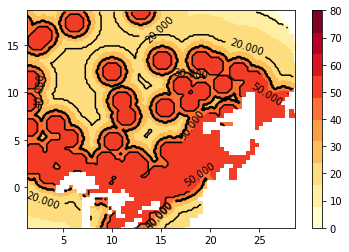

In [60]:
rmse_cont = plt.imshow(100*prho[u:lw, l:r].reshape((lw-u, r-l))/np.nanmax(ds[dv].values[np.argmin(rmse), mc]), origin='lower', aspect='auto', extent=[df_copy.rlon.min(), df_copy.rlon.max(), df_copy.rlat.min(), df_copy.rlat.max()], cmap=plt.cm.get_cmap("YlOrRd", 10), vmin=0., vmax=80.)
plt.colorbar(rmse_cont)
ct = plt.contour(rlon[u:lw, l:r].reshape((lw-u, r-l)), rlat[u:lw, l:r].reshape((lw-u, r-l)), 100*prho[u:lw, l:r].reshape((lw-u, r-l))/np.nanmax(ds[dv].values[np.argmin(rmse), mc]), colors=['black'], levels = np.linspace(10, 80, 8))
plt.clabel(ct, inline=1, fontsize=10)

In [49]:
final_mask*1.0

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(89505,)

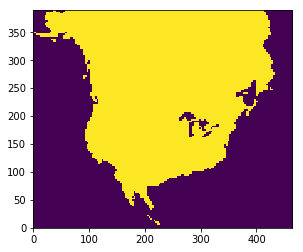

In [50]:
plt.imshow(final_mask, origin='lower')
ds[dv].values[0, final_mask].shape

In [51]:
dsold

<xarray.Dataset>
Dimensions:       (level: 35, rlat: 130, rlon: 155)
Coordinates:
    lon           (rlat, rlon) float64 ...
    lat           (rlat, rlon) float64 ...
  * rlon          (rlon) float64 -33.88 -33.44 -33.0 -32.56 ... 33.0 33.44 33.88
  * rlat          (rlat) float64 -28.6 -28.16 -27.72 ... 27.28 27.72 28.16
  * level         (level) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0
Data variables:
    rotated_pole  int32 ...
    snw           (level, rlat, rlon) float32 nan nan nan nan ... nan nan nan
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Wed Sep 11 10:17:05 2019: cdo setmissval,1.00000002004088e+...
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...